In [54]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import argparse
import os
import unidecode
import string
import random
import time
import math
import torch

from tqdm import tqdm

In [56]:
class Args():
    def __init__(self):
        self.filename = 'filename'
        self.model = "gru"
        self.n_epochs = 2000
        self.print_every = 100
        self.hidden_size = 100
        self.n_layers = 2
        self.learning_rate = 0.01
        self.chunk_len = 200
        self.batch_size = 100
        self.shuffle = True
        self.cuda = False

In [57]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [58]:
# Reading and un-unicode-encoding data

all_characters = string.printable
n_characters = len(all_characters)

def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

# Turning a string into a tensor

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [59]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False, tensor_fn=char_tensor, chars=all_characters):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(tensor_fn(prime_str).unsqueeze(0))

    if cuda:
        hidden = hidden.cuda()
        prime_input = prime_input.cuda()
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = chars[top_i]
        predicted += predicted_char
        inp = Variable(tensor_fn(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.cuda()

    return predicted

In [60]:

def random_training_set(args, file, file_len, tensor_fn=char_tensor):
    inp = torch.LongTensor(args.batch_size, args.chunk_len)
    target = torch.LongTensor(args.batch_size, args.chunk_len)
    for bi in range(args.batch_size):
        start_index = random.randint(0, file_len - args.chunk_len)
        end_index = start_index + args.chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = tensor_fn(chunk[:-1])
        target[bi] = tensor_fn(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    if args.cuda:
        inp = inp.cuda()
        target = target.cuda()
    return inp, target

def train(args, inp, target, decoder, criterion, decoder_optimizer):
    hidden = decoder.init_hidden(args.batch_size)
    if args.cuda:
        hidden = hidden.cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(args.chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(args.batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / args.chunk_len

def save(args, decoder):
    save_filename = os.path.splitext(os.path.basename(args.filename))[0] + '.pt'
    torch.save(decoder, save_filename)
    print('Saved as %s' % save_filename)


In [61]:
args = Args()
args.filename = 'shakespeare.txt'

if torch.cuda.is_available():
    args.cuda = True

if args.cuda:
    print("Using CUDA")

file, file_len = read_file(args.filename)

Using CUDA


In [62]:
from ctypes import c_char_p

# Initialize models and start training

decoder = CharRNN(
    n_characters,
    args.hidden_size,
    n_characters,
    model=args.model,
    n_layers=args.n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss()

if args.cuda:
    decoder.cuda()

start = time.time()
all_losses = []
loss_avg = 0

try:
    print("Training for %d epochs..." % args.n_epochs)
    #for epoch in tqdm(range(1, args.n_epochs + 1)):
    for epoch in tqdm(range(1, 2)):
        loss = train(args, *random_training_set(args, file, file_len, tensor_fn=char_tensor), decoder, criterion, decoder_optimizer)
        loss_avg += loss
        all_losses.append(math.exp(loss))

        if epoch % args.print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / args.n_epochs * 100, loss))
            print(generate(decoder, 'Wh', 100, cuda=args.cuda), '\n')

    print("Saving...")
    save(args, decoder)

except KeyboardInterrupt:
    print("Saving before quit...")
    save(args, decoder)

Training for 2000 epochs...


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

Saving...
Saved as shakespeare.pt


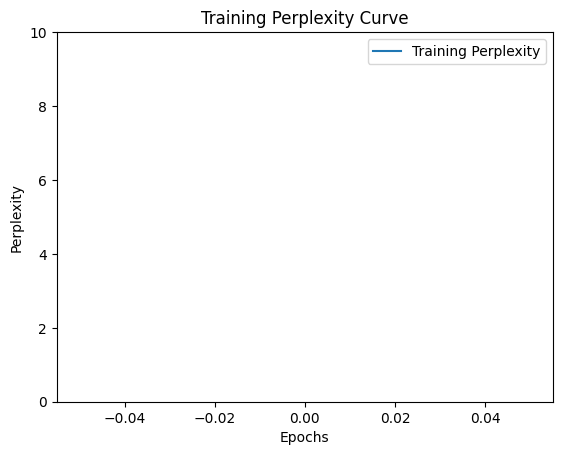

In [63]:
import matplotlib.pyplot as plt

epochs = len(all_losses)
plt.plot(range(epochs), all_losses, label='Training Perplexity')
plt.title('Training Perplexity Curve')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.ylim(0, 10)

# set the legend and display the plot
plt.legend()
plt.show()

## Task 2

In [64]:
decoder = torch.load('shakespeare.pt')

In [38]:
print(generate(decoder, prime_str='hj34s', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters))

hj34s	3ol905&[}}'jja0;%hd2h4]&<6"t\/)/dN	Q2nKFQXzkw
BN


In [39]:
print(generate(decoder, prime_str='2sf 4', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters)))

ICibz mx+|sl_'6~K!*{OnH3]_hHd906e t!],]k1sC t8zzo)<6+9@+Mtl{NCrnn(F2A


In [40]:
print(generate(decoder, prime_str='  3  ', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters)))

  3  tXuQ0["0`*!,lk<ABCH2tTA8]2|dcoclw>A~B0w&]B?DG,z7=~Gnow3q'I=0tto(,|8yEe-9alP1	%QH?GNV[%ZmouSt}&+]K


## Task 3

In [41]:
print(generate(decoder, prime_str='The', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters)))

 +xm'Oun2qz[2$tlp#_IY3	P&%4)fq7{P>t:.W'SHtCxFk["yaYcaB|h'kd)`Cn#V'X}4\1nDZ8yQ@!


In [42]:
print(generate(decoder, prime_str='What is', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters)))

RI[}K^h?Y'^26>2qBK.tb -s/WiO2l*VR]cnBKu?\z'i2~GpU:`lo[ rr$q^_:-h[+TUqY u4
k-sgVH'c


In [43]:
print(generate(decoder, prime_str='Shall I give', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters)))

ZT{a%[R -={
Db/Hsea/NTh<3F!e{&v"TJPak[;|inaOg%s


In [44]:
print(generate(decoder, prime_str='X087hNYB BHN BYFVuhsdbs', cuda=args.cuda, tensor_fn=char_tensor, chars=all_characters)))

X087hNYB BHN BYFVuhsdbs;^9+%1C<3rI$DhLATBIP$Fycnc{nk&EMjDJl7B|q0
#v	^,OtzSNq`d.p9Kun; O+Qyx2"cHn?+Y0!WVW99	ds2Dlqk}g2p%b


In [50]:
all_words = list(dict.fromkeys(file.split()))
n_words = len(all_words)

# Turning a string into a tensor
def word_tensor(string):
    words = string.split()
    tensor = torch.zeros(len(words)).long()
    for word in range(len(words)):
        try:
            tensor[word] = all_words.index(words[word])
        except:
            continue
    return tensor


In [53]:
word_tensor("First Citizen: Before we proceed any further, hear me speak. All: Speak, speak.")

tensor([ 119, 4205,    9,    0,  240,   11, 3040])

In [ ]:
# Initialize models and start training

word_decoder = CharRNN(
    n_words,
    args.hidden_size,
    n_words,
    model=args.model,
    n_layers=args.n_layers,
)
word_decoder_optimizer = torch.optim.Adam(word_decoder.parameters(), lr=args.learning_rate)
word_criterion = nn.CrossEntropyLoss()

if args.cuda:
    decoder.cuda()

start = time.time()
all_losses = []
loss_avg = 0

try:
    print("Training for %d epochs..." % args.n_epochs)
    for epoch in tqdm(range(1, args.n_epochs + 1)):
    #for epoch in tqdm(range(1, 2)):
        loss = train(args, *random_training_set(args, file, file_len, tensor_fn=word_tensor), word_decoder, word_criterion, word_decoder_optimizer)
        loss_avg += loss
        all_losses.append(math.exp(loss))

        if epoch % args.print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / args.n_epochs * 100, loss))
            print(generate(decoder, 'Wh', 100, cuda=args.cuda), '\n')

    print("Saving...")
    save(args, word_decoder)

except KeyboardInterrupt:
    print("Saving before quit...")
    save(args, word_decoder)